# Neural Style Transfer

#### Intuition

Why this particular topic? In a regression or classification problem the input is fixed and we optimize an objective function with regard to parameters, i.e. we tweak the parameters until the objective function is optimized. In a neural style transfer, the optimization is performed on the input data and the parameters are preset (pre-trained). So this represents a drastically different angle for optimization than we usually take. But there's also a connection to time series

We'll generate an image that is a blend between the content of a input image and the style of another input image. We'll acomplish this by balancing the content loss and the style loss of the blended image simultaneously.

Convolutional Neural Networks (CNNs) are very good at extracting features from an image: horizontal, vertical, diagonal, triangles, circles, squares etc. So when we're passing as input the content picture, the CNN extracts just the essence of the input. The rest is filled with the style coming form the second input.

But what is style? Abstract concept. Algorithm-wise, the style is the result of performing convolutions on the input image that serves as the style template, computing its Gram matrix and using the ensuing result in the style square loss calculation. Sounds like a mouthful. Why does this even work? The functional form of the Gram matrix looks very close to the autocorrelation matrix. Autocorrelation is the correlation of the data with itself. It appears often in the context of time series and is used for multiple things, one of which is the study of seasonality: patterns that repeat with time. So what we're essentially doing is extracting the patterns of the input image designated as the style input. Style is a form of a repeating pattern, so there we have it, the intuition behind the abstraction.

### Import the working libraries

In [24]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

from style_transfer1 import VGG16_AvgPool, VGG16_AvgPool_CutOff, unpreprocess, scale_img
from style_transfer2 import gram_matrix, style_loss, minimize

# disable warnings
import warnings
warnings.filterwarnings("ignore")

### Load the images

Define the input style and input content

In [25]:
STYLE = 'KlimtKiss.jpg'
CONTENT = 'kissTIME.jpg'
 
# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

content_img = load_img_and_preprocess(CONTENT)

# resize the style image
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(STYLE,(h, w))

### Show the images

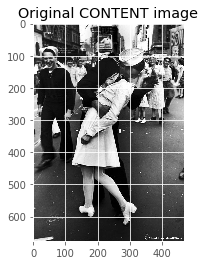

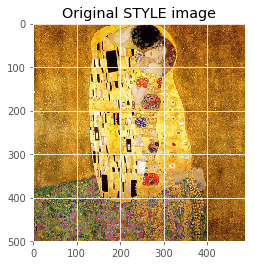

In [26]:
# plot the original images
path1 = CONTENT
img1 = image.load_img(path1)
content_orig = image.img_to_array(img1)

path2 = STYLE    
img2 = image.load_img(path2)
style_orig = image.img_to_array(img2)

def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

plt.imshow(scale_img(content_orig))
plt.title('Original CONTENT image')
plt.show()

plt.imshow(scale_img(style_orig))
plt.title('Original STYLE image')
plt.show()

### Prep content for convolution

In [27]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

### Create the content  model

In [28]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# the pretrained model
vgg = VGG16_AvgPool(shape)
vgg.summary()

# the content model
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0)) 
content_target = K.variable(content_model.predict(content_img))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 676, 468, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 676, 468, 64)      36928     
_________________________________________________________________
average_pooling2d_11 (Averag (None, 338, 234, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 338, 234, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 338, 234, 128)     147584    
_________________________________________________________________
average_pooling2d_12 (Averag (None, 169, 117, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 169, 117, 256)     295168    
__________

### Create the style  model

In [29]:
# create the style model
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1 and only weight the style losses
style_weights = [0.02,0.1,0.03,0.1,0.2]

### Loss functions

Compute the total loss which is the sum of content + style loss

In [30]:
# Content loss
loss = K.mean(K.square(content_model.output - content_target))

# Style loss
for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0]) # w represents the style weight

# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)


get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)

### Optimize



Infusing CONTENT with STYLE...

epoch=0, loss=1086.3187255859375, epoch duration = 0:01:06.676014, total min = 1.111
epoch=1, loss=244.8135223388672, epoch duration = 0:02:05.898843, total min = 2.098
epoch=2, loss=167.63845825195312, epoch duration = 0:03:03.373277, total min = 3.056
epoch=3, loss=138.8682403564453, epoch duration = 0:04:01.754878, total min = 4.029
epoch=4, loss=123.85179901123047, epoch duration = 0:05:00.810309, total min = 5.014
epoch=5, loss=113.51190948486328, epoch duration = 0:05:58.673372, total min = 5.978
epoch=6, loss=105.932373046875, epoch duration = 0:06:57.117149, total min = 6.952
epoch=7, loss=100.95965576171875, epoch duration = 0:07:57.614135, total min = 7.960
epoch=8, loss=96.09154510498047, epoch duration = 0:08:56.090929, total min = 8.935
epoch=9, loss=92.48357391357422, epoch duration = 0:09:54.740376, total min = 9.912

Total duration: 55.046 min


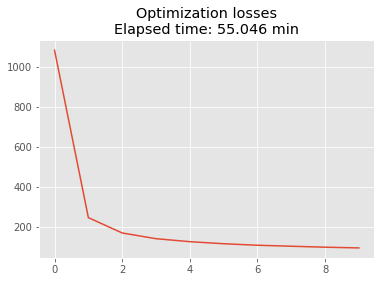

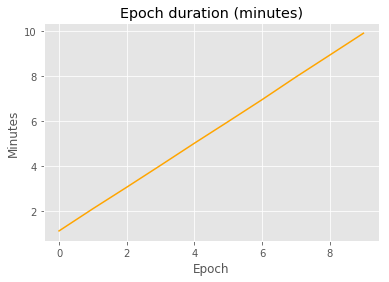

In [31]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)

### Show blended image

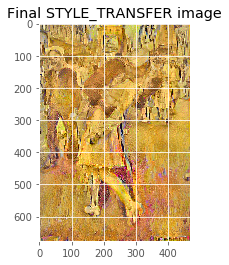

In [32]:
plt.imshow(scale_img(final_img))
plt.title('Final STYLE_TRANSFER image')
plt.show()

# Conclusion

In this project we presented a new optimization paradigm, one that modifies the input (the output of the convolutional layers) in order to optimize the objective function as opposed to modifying the network parameters (the weight matrix). We also found an intuition for style and a way to express it.